In [14]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import os
import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# import functions
from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss, TiDE_forward


cuda is available


In [15]:
from policy import PolicyNN
model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)


model.load_state_dict(torch.load("policy_model_0630_3L_1024H.pth", map_location="cpu"))



<All keys matched successfully>

In [16]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50 #50 

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)[:,-window:] # shape = [2,50]

100%|██████████| 250/250 [00:05<00:00, 45.07it/s]


In [17]:
df_one_print = pd.read_csv('single_track_ref.csv')

loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)

# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)

# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

# fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# temporary ref
# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

In [18]:
print("loc_X_list shape:", loc_X_list.shape)
print("loc_Y_list shape:", loc_Y_list.shape)
print("loc_Z_list shape:", loc_Z_list.shape)
print("dist_X_list shape:", dist_X_list.shape)
print("dist_Y_list shape:", dist_Y_list.shape)
print("scan_spd_list shape:", scan_spd_list.shape)
print("laser_on_off shape:", laser_on_off.shape)

print("laser_power_ref shape:", laser_power_ref.size())
print("laser_power_past shape:", laser_power_past.size())

print("fix_covariates shape:", fix_covariates.size())
print("mp_temp_ref shape:", mp_temp_ref.size())

loc_X_list shape: (6295, 1)
loc_Y_list shape: (6295, 1)
loc_Z_list shape: (6295, 1)
dist_X_list shape: (6295, 1)
dist_Y_list shape: (6295, 1)
scan_spd_list shape: (6295, 1)
laser_on_off shape: (6295, 1)
laser_power_ref shape: torch.Size([6295, 1])
laser_power_past shape: torch.Size([50, 1])
fix_covariates shape: torch.Size([6295, 3])
mp_temp_ref shape: torch.Size([6295])


In [19]:
import torch

# values from user
x_min = torch.tensor([[0.0, 0.75, 0.75, 504.26]], dtype=torch.float32).to(device)
x_max = torch.tensor([[7.5, 20.0, 20.0, 732.298]], dtype=torch.float32).to(device)

y_min = torch.tensor([[436.608, -0.559]], dtype=torch.float32).to(device)
y_max = torch.tensor([[4509.855, 0.551]], dtype=torch.float32).to(device)


In [20]:
def normalize_x(x, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 2 * (x - x_min_selected) / (x_max_selected - x_min_selected) - 1

def inverse_normalize_x(x_norm, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 0.5 * (x_norm + 1) * (x_max_selected - x_min_selected) + x_min_selected

def normalize_y(y, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 2 * (y - y_min_selected) / (y_max_selected - y_min_selected) - 1

def inverse_normalize_y(y_norm, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 0.5 * (y_norm + 1) * (y_max_selected - y_min_selected) + y_min_selected


In [21]:
def run_one_step_policy(GAMMA_obj, policy_model, P, window):
    # Reference trajectory for temperature (original scale)
    mp_temp_ref = GAMMA_obj.ref[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P]
    mp_temp_ref_t = torch.tensor(mp_temp_ref, dtype=torch.float32).reshape(1, P, 1).to(device)

    # Prepare past input (original scale)
    mp_temp_past_t = GAMMA_obj.x_past.T.unsqueeze(0).to(device)          # [1, 50, 2]
    laser_past_t = GAMMA_obj.u_past.reshape(1, -1, 1).to(device)         # [1, 50, 1]
    fix_cov_past = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter - window : GAMMA_obj.MPC_counter, :]
    fix_cov_past_t = fix_cov_past.reshape(1, window, -1).to(device)      # [1, 50, 3]

    # Normalize each part
    fix_cov_past_s = normalize_x(fix_cov_past_t, dim_id=[0,1,2])         # [1, 50, 3]
    laser_past_s   = normalize_x(laser_past_t, dim_id=[3])               # [1, 50, 1]
    mp_temp_past_s = normalize_y(mp_temp_past_t, dim_id=[0,1])         # [1, 50, 1]


    policy_in_past = torch.cat((fix_cov_past_s, laser_past_s, mp_temp_past_s), dim=2)  # [1, 50, 6]

    # Future covariates (original scale)
    fix_cov_future = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P, :]
    fix_cov_future_t = fix_cov_future.reshape(1, P, -1).to(device)       # [1, P, 3]
    fix_cov_future_s = normalize_x(fix_cov_future_t, dim_id=[0,1,2])     # [1, P, 3]

    #mp_temp_ref_s = normalize_y(mp_temp_ref_t)[:, :, 0].unsqueeze(-1)                         # [1, P, 1]
    mp_temp_ref_s = normalize_y(mp_temp_ref_t, dim_id=[0])[:, :, 0].unsqueeze(-1)

    # constraint (original scale) - no scaling
    depth_upper_const = 0.4126
    depth_lower_const = 0.1423
    y_const_t = torch.tensor([[depth_upper_const, depth_lower_const]] * P, dtype=torch.float32).reshape(1, P, 2).to(device)
    y_const_s = normalize_y(y_const_t, dim_id=[1])


    policy_in_future = torch.cat((fix_cov_future_s, mp_temp_ref_s, y_const_s), dim=2)  # [1, P, 6]

    # Policy inference
    u_pred = policy_model((policy_in_past, policy_in_future))
    u_pred = u_pred[0] if u_pred.dim() == 3 else u_pred
    #u_pred_clamped = torch.clamp(u_pred, -1, 1)
    u_applied = float(inverse_normalize_x(u_pred[0], dim_id=[3]))  # Convert to original scale

    # Simulator step
    x_current, depth_current = GAMMA_obj.run_sim_interval(u_applied)

    # Update window (original scale)
    GAMMA_obj.x_past[:, :-1] = GAMMA_obj.x_past[:, 1:]
    GAMMA_obj.x_past[0, -1] = torch.tensor(x_current, dtype=torch.float32)
    GAMMA_obj.x_past[1, -1] = torch.tensor(depth_current, dtype=torch.float32)

    GAMMA_obj.u_past[:-1] = GAMMA_obj.u_past[1:].clone()
    GAMMA_obj.u_past[-1] = torch.tensor(u_applied, dtype=torch.float32)

    GAMMA_obj.x_hat_current = torch.tensor([x_current, depth_current])
    GAMMA_obj.x_sys_current = torch.tensor([[x_current], [depth_current]])
    GAMMA_obj.MPC_counter += 1

    # Log (original scale)
    GAMMA_obj.x_past_save = torch.cat((GAMMA_obj.x_past_save, torch.tensor([[x_current, depth_current]])), dim=0)
    GAMMA_obj.u_past_save = torch.cat((GAMMA_obj.u_past_save, torch.tensor([[u_applied]])), dim=0)


In [22]:
def plot_fig(MPC_GAMMA, N_step):
    plt.figure(figsize=[12,10])
    plt.subplot(3,1,1)
    plt.plot(MPC_GAMMA.x_past_save[:N_step,0], label = "GAMMA simulation")
    plt.plot(MPC_GAMMA.ref[:N_step], label="Reference")
    plt.legend()


    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.ylabel("Melt Pool Temperature (k)")

    plt.subplot(3,1,2)
    plt.plot(MPC_GAMMA.x_past_save[:N_step,1], label = "GAMMA simulation")
    plt.plot(np.linspace(0,N_step,N_step),0.225*np.ones(N_step))
    plt.plot(np.linspace(0,N_step,N_step),0.075*np.ones(N_step))
    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.ylabel("Melt Pool Depth (mm)")
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(MPC_GAMMA.u_past_save[:N_step])
    plt.ylabel("Laser power (w)")
    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.show()

  0%|          | 0/6245 [00:00<?, ?it/s]

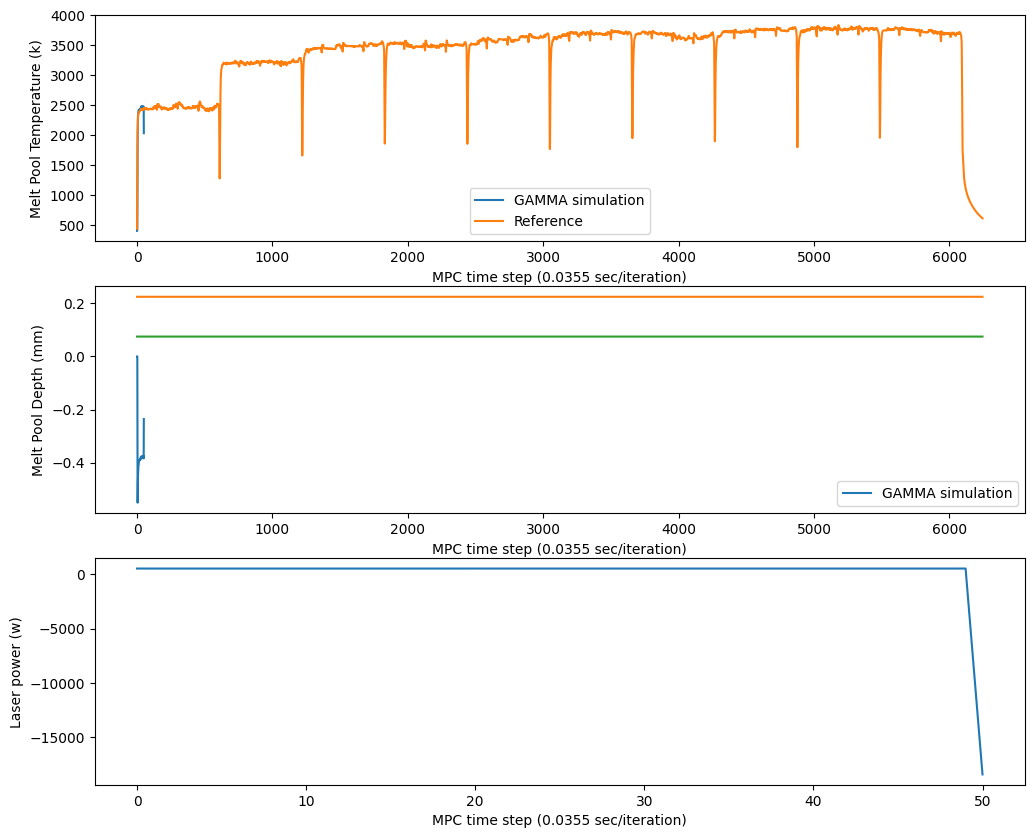

  5%|▍         | 300/6245 [00:31<10:09,  9.75it/s]

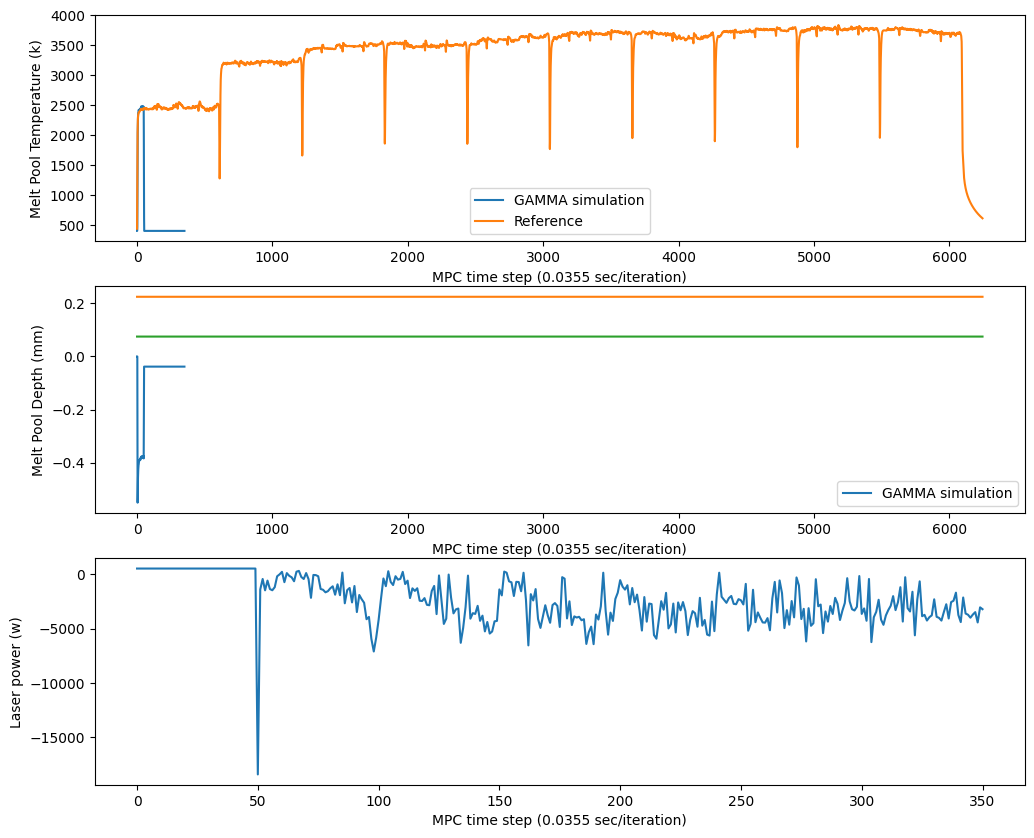

  8%|▊         | 478/6245 [00:50<10:04,  9.54it/s]

In [ ]:
# step 수 결정
P = 50
N_step = len(mp_temp_ref) - P

# logging 변수 초기화 (기존 GAMMA_MPC 내부에서 하던 것)
GAMMA_class.ref = mp_temp_ref
GAMMA_class.fix_cov_all = fix_covariates
GAMMA_class.x_past = init_avg.clone()
GAMMA_class.u_past = laser_power_past.clone()
GAMMA_class.MPC_counter = P  # 혹은 init_runs도 가능

GAMMA_class.x_hat_current = GAMMA_class.x_past[:, -1]
GAMMA_class.x_sys_current = GAMMA_class.x_past[:, -1].reshape(2, 1)

GAMMA_class.x_past_save = GAMMA_class.x_past.T.clone()
GAMMA_class.u_past_save = GAMMA_class.u_past.clone()

# 실행 루프
from tqdm import tqdm

for i in tqdm(range(N_step)):
    run_one_step_policy(GAMMA_class, model, P=P, window=window)

    if i % 300 == 0:
        plot_fig(GAMMA_class, N_step)
